# Linear Mixed-effects Models

Welcome for the first practical session of the day !

## Objectives : 
- Get a better idea of medical data, especially longitudinal ones
- Understand mixed-effects models
- Get a taste of state-of-the-art techniques


## The set-up

If you have followed the [installation details](https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions) carefully, you should 

- be running this notebook in the `leaspy_tutorial` conda environment (be sure that the kernel you are using is `leaspy_tutorial` => check `Kernel` above)
- having all the needed packages already install

<span style='color: #a13203; font-weight: 600;'>💬 Question 1 💬</span> Run the following command lines

In [1]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Part I: The data

We import a functional medical imaging dataset. We have extracted, for each timepoint, the average value of the metabolic activity of the _putamen_. This brain region is commonly damaged by _Parkinson's disease_.

IMPORTANT: The values have been normalized such that a _normal value_ is zero and a _very abrnomal value_ is one. 

<span style='color: #a13203; font-weight: 600;'>💬 Question 2 💬</span> Run the following cell and look at the `head` of the dataframe to better understand what the data are.

In [2]:
from leaspy.datasets import Loader
df = Loader.load_dataset('parkinson-putamen-train_and_test')

In [3]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df.head()

PUTAMEN
ID     TIME      SPLIT          
GS-001 71.354607 train  0.728492
       71.554604 train  0.735620
       72.054604 train  0.757409
       73.054604 train  0.800754
       73.554604 train  0.870756

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> The `SPLIT` column already distinguishes the train and test data.

<span style='color: #a13203; font-weight: 600;'>💬 Question 3 💬</span> Describe the target variable `PUTAMEN` and the explicative variable `TIME`. You can plot:

- Sample size
- Mean, std
- Min & max values
- Quantiles

In [4]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df.reset_index().describe().round(2).T

count   mean    std    min    25%    50%    75%    max
TIME     1997.0  65.37  10.05  33.14  58.66  66.48  72.06  91.24
PUTAMEN  1997.0   0.71   0.10   0.35   0.64   0.71   0.77   0.96

<span style='color: #a13203; font-weight: 600;'>💬 Question 4 💬</span> From this value, what can you say about the disease stage of the population?

Your answer: ...

 Answer:
The median and mean value is 0.71, so the average disease stage is high for these subjects.

<span style='color: #a13203; font-weight: 600;'>💬 Question 5 💬</span> Display the data, where the Putamen (y-axis) is plot with respect to the Time (x-axis)

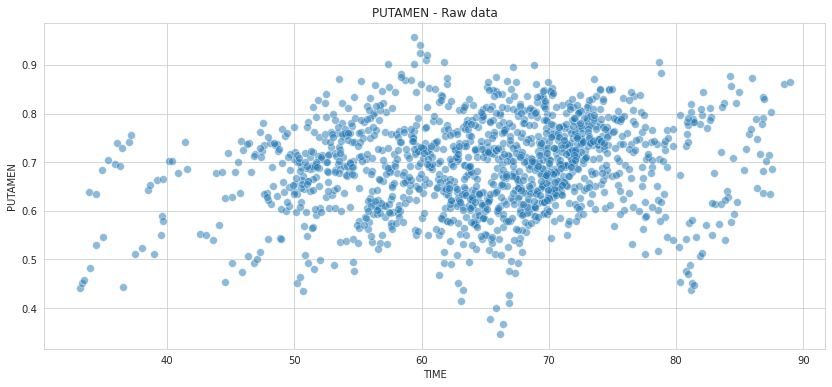

In [5]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

sns.set_style('whitegrid')
plt.figure(figsize=(14,6))
sns.scatterplot(data=df.xs('train', level='SPLIT').reset_index(), 
                x='TIME', y='PUTAMEN', alpha=.5, s=60)
plt.title('PUTAMEN - Raw data')
plt.show()

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> At first look, the _PUTAMEN values_ do not seem highly correlated to _TIME_.


## Part II: Linear Regression

As we are some pro ML players, let's make some predictions : let's try to predict the putamen value based on the time alone.

<span style='color: #a13203; font-weight: 600;'>💬 Question 6 💬</span> Store the train and test data in `df_train` and `df_test`

In [6]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

pds = pd.IndexSlice
df_train = df.loc[pds[:, :, 'train']].copy()  # one possibility
df_test = df.xs('test', level='SPLIT').copy()  # an other one

<span style='color: #a13203; font-weight: 600;'>💬 Question 7 💬</span> Run the linear reagression that is in scipy. 

Be carefull, you have to train it only with the train set!

In [7]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

x = df_train.index.get_level_values('TIME').values
y = df_train['PUTAMEN'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> To run the notebook smoothly, you must comply to the following rules: we are going to try different models to predict the putamen values based on each observation.

We will store the results in the dataframe `df` such that : 

| ID | TIME | SPLIT | PUTAMEN | Model 1 | Model 2 | ... |
| --- | --- | --- | --- | --- | --- | --- |
| GS-001 | 74.4 | train | 0.78 | 0.93 | 0.75 | ... |
| GS-003 | 75.4 | train | 0.44 | 0.84 | 0.46 | ... |
| GS-018 | 51.8 | test | 0.71 | 0.73 | 0.78 | ... |
| GS-056 | 89.2 | train | 0.76 | 0.56 | 0.61 | ... |

This will ease the comparison of the models. 

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> No need to add these predictions to `df_train` and `df_test`. You should be able to easily run the notebook by keeping `df_train` the way it is while appending the results in `df`.

<span style='color: #a13203; font-weight: 600;'>💬 Question 8 💬</span> Add the predictions done by the linear regression in the column `Linear Regression`

In [8]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df['Linear Regression'] = intercept + slope * df.index.get_level_values('TIME')

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Let's introduce an object and a fonction that will be used to compare the models: 
- `overall_results` will be the dataframe that stores the root mean square error on the train and test set for the different models

- `compute_rmse_train_test` is the function that given the dataframe `df` and a `model_name` (`Linear Regression` for instance), compute the mean absolute error on the train and test set and stores it in `overall_results`

<span style='color: #a13203; font-weight: 600;'>💬 Question 9 💬</span> Run the following cell to see the results

In [9]:
overall_results = pd.DataFrame({'train': [], 'test': []})  


def compute_rmse(df, model_name):
    """Compute RMSE between PUTAMEN column and the <model_name> column of df"""
    y = df['PUTAMEN']
    y_hat = df[model_name]
    diff = y - y_hat
    return np.sqrt(np.mean(diff * diff))


def compute_rmse_train_test(df, overall_results, model_name):
    """Inplace modification of <overall_results>"""
    overall_results.loc[model_name, 'train'] = compute_rmse(df.xs('train', level='SPLIT'), model_name)
    overall_results.loc[model_name, 'test'] = compute_rmse(df.xs('test', level='SPLIT'), model_name)

compute_rmse_train_test(df, overall_results, 'Linear Regression')
overall_results

train     test
Linear Regression  0.091403  0.10213

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> The RMSE is higher on the test set as on the train set


Let's look at what we are doing by plotting the data and the linear regression. Throughout the notebook, we will use the function `plot_individuals` that, given a subset of IDs and a model name (as stored in the `df` dataframe) plots the individual data and their prediction

<span style='color: #a13203; font-weight: 600;'>💬 Question 10 💬</span> Use the following cell. 

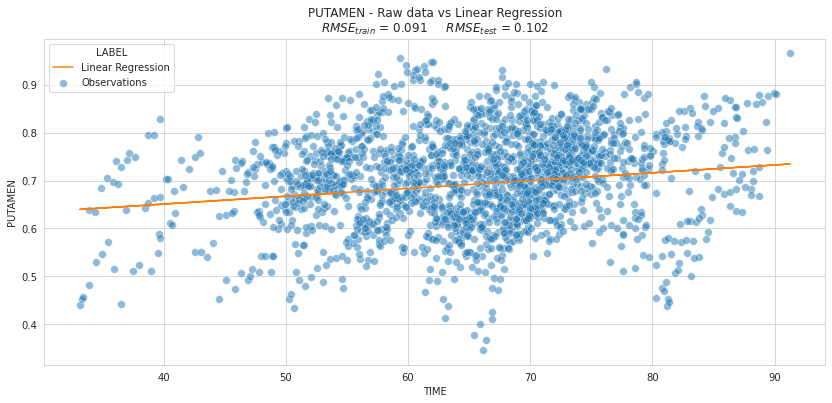

In [10]:
def get_title(overall_results, model_name):
    """Precise model's name and its RMSE train & test"""
    rmse_train = overall_results.loc[model_name, 'train']
    rmse_test = overall_results.loc[model_name, 'test']
    title = f'PUTAMEN - Raw data vs {model_name:s}\n'
    title += r'$RMSE_{train}$ = %.3f     $RMSE_{test}$ = %.3f' % (rmse_train, rmse_test)
    return title

    
def plot_individuals(df, overall_results, model_name, **kwargs):
    # ---- Input manager
    kind = kwargs.get('kind', 'lines')
    sublist = kwargs.get('sublist', None)
    highlight_test = kwargs.get('highlight_test', True)
    ax = kwargs.get('ax', None)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    else:
        plt.figure(figsize=(14, 6))
    
    # ---- Select subjects
    if sublist is None:
        sublist = df.index.unique('ID')
        
    # ---- If too many subject, do not display them in the legend
    display_id_legend = len(sublist) <= 10
    
    # ---- Plot
    if kind == 'scatter':
        # -- Used for Linear Regression
        sns.scatterplot(data=df.reset_index(), x='TIME', y='PUTAMEN', alpha=.5, 
                        s=60, label='Observations', ax=ax)
        ax.plot(df.index.get_level_values('TIME').values,
                df[model_name].values, 
                label=model_name, c='C1')
        ax.legend(title='LABEL')
        if highlight_test:
            test = df.xs('test', level='SPLIT').loc[sublist].reset_index()
            sns.scatterplot(data=test, x='TIME', y='PUTAMEN', legend=None, ax=ax)
        
    elif kind == 'lines':
        # -- Used for the other models
        # - Stack observations & reconstructions by the model
        df_stacked = df[['PUTAMEN', model_name]].copy()
        df_stacked.rename(columns={'PUTAMEN': 'Observations'}, inplace=True)
        df_stacked = df_stacked.stack().reset_index().set_index(['ID', 'SPLIT'])
        df_stacked.columns = ['TIME', 'LABEL', 'PUTAMEN']
        
        # - Plot
        sns.lineplot(data=df_stacked.loc[sublist], 
                     x='TIME', y='PUTAMEN', hue='ID', style='LABEL', 
                     legend=display_id_legend, ax=ax)
        if highlight_test:
            test = df.xs('test', level='SPLIT').loc[sublist].reset_index()
            sns.scatterplot(data=test, x='TIME', y='PUTAMEN', hue='ID', legend=None, ax=ax)
        if display_id_legend:
            ax.legend(title='LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        raise ValueError('<kind> input accept only "scatter" and "lines".'
                         f' You gave {kind}')
        
    ax.set_title(get_title(overall_results, model_name))
    return ax
    
plot_individuals(df, overall_results, 'Linear Regression', 
                 kind='scatter', highlight_test=False)
plt.show()

Is the previous plot relevant to assess the quality of our model?

We will answer this question in the following cells:

## Part III: The longitudinal aspect


<span style='color: #a13203; font-weight: 600;'>💬 Question 11 💬</span> Run the cell to have a better understanding of your data:

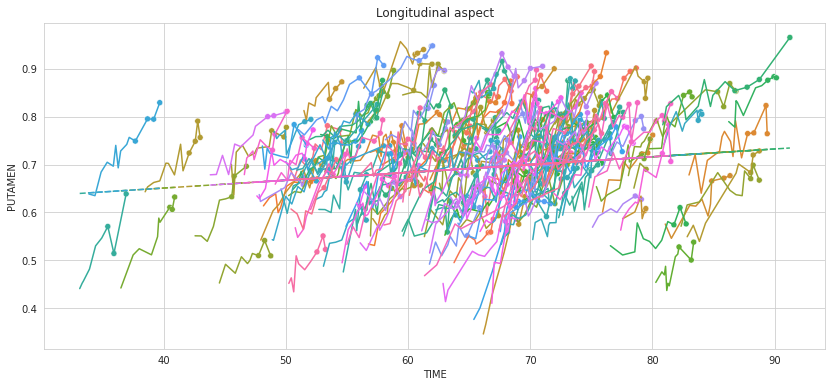

In [11]:
plot_individuals(df, overall_results, 'Linear Regression', 
                 kind='lines', highlight_test=True)
plt.title('Longitudinal aspect')
plt.show()

The test data are highlited with dots.
<span style='color: #a13203; font-weight: 600;'>💬 Question 12 💬</span> What are actually the test data ?

Your answer: The test data are the last view/most recent data points from each individual.

<span style='color: #a13203; font-weight: 600;'>💬 Question 13 💬</span>Why does the global linear model not describe the temporal evolution of the variable?

Your answer: The global linear model does not consider an individuals trajectory but the overall relation of age and the biomarker.

## PART IV: Indivual Linear Regressions


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> In fact, this is not the best idea to have one general linear regression. Because we do not benefit from indiviudal information. Therefore, let's do one linear regression per individual

<span style='color: #a13203; font-weight: 600;'>💬 Question 14 💬</span> Look at what this function is doing and at the result

In [12]:
individual_parameters = pd.DataFrame({'INTERCEPT': [], 'SLOPE': []})

subject_idx = 'GS-194'

def compute_individual_parameters(df, subject_idx):
    df_patient = df.loc[subject_idx]
    
    x = df_patient.index.get_level_values('TIME').values
    y = df_patient['PUTAMEN'].values
    
    # -- Linear regression
    slope, intercept, _, _, _ = stats.linregress(x, y)
    
    
    return intercept, slope


individual_parameters.loc[subject_idx] = compute_individual_parameters(df_train, subject_idx)

individual_parameters

INTERCEPT     SLOPE
GS-194  -0.807941  0.025188

<span style='color: #a13203; font-weight: 600;'>💬 Question 15 💬</span> Apply the function to everyone 

In [13]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #


for subject_idx in df_train.index.unique('ID'):
   
    intercept,slope = compute_individual_parameters(df_train, subject_idx)
    individual_parameters.loc[subject_idx] = (intercept, slope)
    
individual_parameters.head()

INTERCEPT     SLOPE
GS-194  -0.807941  0.025188
GS-001  -2.946305  0.051464
GS-002  -0.252949  0.018643
GS-003   0.517972  0.003816
GS-004  -1.076280  0.025680

<span style='color: #a13203; font-weight: 600;'>💬 Question 16 💬</span> __Now append the result of the model in `df` using the function below.__

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> Take a close look at what we are doing cause we will use the same syntax if other questions.

In [14]:
def compute_individual_reconstruction(x, parameters):
    
    subject_idx = x.name[0]
    
    slope = parameters.loc[subject_idx]['SLOPE']
    intercept = parameters.loc[subject_idx]['INTERCEPT']
    
    time = x.name[1]
    
    return intercept + slope * time
    
    

df['Individual Linear Regression'] = df.apply(
    lambda x: compute_individual_reconstruction(x, individual_parameters), axis=1)

<span style='color: #a13203; font-weight: 600;'>💬 Question 17 💬</span> Use the `compute_train_test_mean_absolute_error` function to get the train and test errors and compare the two models.

In [15]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

compute_rmse_train_test(df, overall_results, 'Individual Linear Regression')
overall_results

train      test
Linear Regression             0.091403  0.102130
Individual Linear Regression  0.017825  0.032197

We clearly see that the RMSE is much better!
<span style='color: #a13203; font-weight: 600;'>💬 Question 18 💬</span> Create a list with the five patients having the more visits and the five patients having the less visits, then use `plot_individuals` function to display their observations and reconstructions by the model
_Hint_ : use the keyword `sublist`

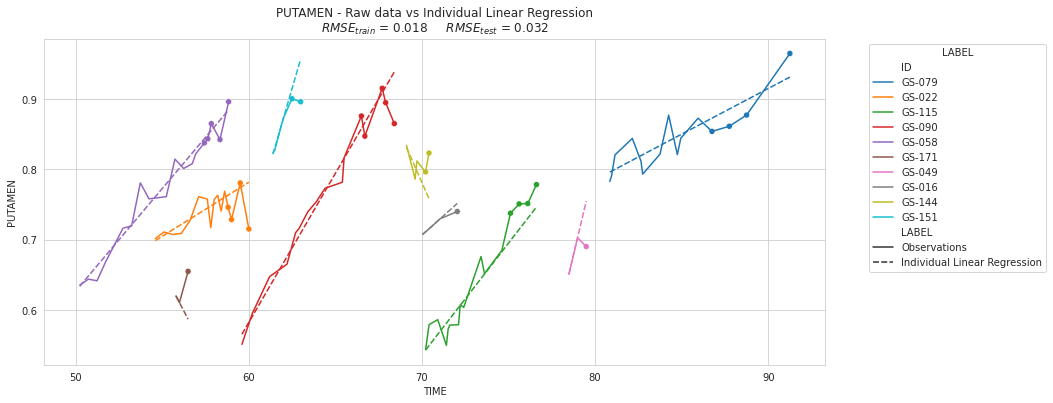

In [16]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

visits_per_subjects = df.groupby(df.index.get_level_values('ID')).count().sort_values('PUTAMEN')
sublist = visits_per_subjects.tail(5).index.tolist()
sublist += visits_per_subjects.head(5).index.tolist()

plot_individuals(df, overall_results, 'Individual Linear Regression', sublist=sublist)
plt.show()

<span style='color: #a13203; font-weight: 600;'>💬 Question 19 💬</span> Explain why $RMSE_{test} >> RMSE_{train}$:

**Answer**: the LM overfit for patients with only few data

## Part V : Linear Mixed effects Model with `statsmodels`
With the previous method, we made a significant improvement. However, we suffer fro an overfitting problem. Let's see what a _mixed effect model_ can do for us!

### Run a LMM with `statsmodels`

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> We will use the `statsmodel` package to run a Linear Mixed Effect Model (LMM or LMEM in the literature).


<span style='color: #a13203; font-weight: 600;'>💬 Question 20 💬</span> Load the following lines to import the packages

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

`Statsmodels` contains several _API_ to create a model. For the ones familiar with _R_, you will be here in a familiar ground with the _formula API_.
- `formula='PUTAMEN ~ TIME + 1'` means that you want to explain _PUTAMEN_ with _TIME_ and an _intercept_
- `groups="ID"` means that you want random effect for all levels of _ID_
- `re_formula="~TIME + 1"` means that you want a random intercept and a random slope for _TIME_

If you go back to the equation you get :
$ PUTAMEN_{id,time} = \underbrace{\alpha*TIME_{id,time} + \beta}_\text{formula} + \underbrace{\alpha_{id}*TIME_{id,time} + \beta_{id}}_\text{re_formula}$

<span style='color: #a13203; font-weight: 600;'>💬 Question 21 💬</span> Let's try a very **_naive_** run:

In [18]:
lmm = smf.mixedlm(formula='PUTAMEN ~ 1 + TIME', 
                  data=df_train.reset_index(), 
                  groups="ID", re_formula="~ 1 + TIME").fit()
lmm.summary()

/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarn

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: PUTAMEN  
No. Observations:   1415    Method:             REML     
No. Groups:         200     Scale:              0.0007   
Min. group size:    2       Log-Likelihood:     2497.0458
Max. group size:    13      Converged:          No       
Mean group size:    7.1                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.685    0.044 -15.644 0.000 -0.771 -0.599
TIME           0.022    0.001  29.528 0.000  0.020  0.023
ID Var         0.003    0.259                            
ID x TIME Cov  0.000    0.005                            
TIME Var       0.000    0.000                            
=========================================================

"""

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> Let's skip the different warning for now and see what happens if we ignore it

Let's try and see.

<span style='color: #a13203; font-weight: 600;'>💬 Question 22 💬</span> Run the following commands to get the intercept and slope

In [19]:
print(lmm.fe_params.loc['Intercept'])
print(lmm.fe_params.loc['TIME'])

-0.6848661093834492
0.021679337384131487


<span style='color: #a13203; font-weight: 600;'>💬 Question 23 💬</span> Run the following commands to get the variation to the mean slope and intercept
Example on few subject

In [20]:
{key: val for key, val in lmm.random_effects.items() if key in 
 ['GS-00'+str(i) for i in range(1, 4)]}

{'GS-001': ID     -0.019149
 TIME   -0.001092
 dtype: float64,
 'GS-002': ID      0.058495
 TIME    0.004182
 dtype: float64,
 'GS-003': ID     -0.011974
 TIME   -0.001002
 dtype: float64}

<span style='color: #a13203; font-weight: 600;'>💬 Question 24 💬</span> From the fixed and random effects, compute for each subject its INTERCEPT and SLOPE:

In [21]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df_random_effects = pd.DataFrame.from_dict(lmm.random_effects, orient='index')
df_random_effects = df_random_effects.rename({'ID': 'Random intercept', 'TIME': 'Random slope'}, axis=1)

df_random_effects['INTERCEPT'] = df_random_effects['Random intercept'] + lmm.fe_params.loc['Intercept']
df_random_effects['SLOPE'] = df_random_effects['Random slope'] + lmm.fe_params.loc['TIME']

df_random_effects.head()

Random intercept  Random slope  INTERCEPT     SLOPE
GS-001         -0.019149     -0.001092  -0.704015  0.020588
GS-002          0.058495      0.004182  -0.626371  0.025861
GS-003         -0.011974     -0.001002  -0.696840  0.020677
GS-004         -0.020968     -0.001529  -0.705834  0.020150
GS-005          0.006285      0.000363  -0.678581  0.022043

<span style='color: #a13203; font-weight: 600;'>💬 Question 25 💬</span> Use the `compute_individual_reconstruction` function but with `df_random_effects` to compute the prediction with the new individual effects

In [22]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df['Linear Mixed Effect Model'] = df.apply(
    lambda x: compute_individual_reconstruction(x, df_random_effects), axis=1)

<span style='color: #a13203; font-weight: 600;'>💬 Question 26 💬</span> __Store the results in `overall_results` (thanks to `compute_rmse_train_test` function) and compare the models__

In [23]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

compute_rmse_train_test(df, overall_results, 'Linear Mixed Effect Model')

overall_results

train      test
Linear Regression             0.091403  0.102130
Individual Linear Regression  0.017825  0.032197
Linear Mixed Effect Model     0.024533  0.039367

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> The result is worse than with the previous model. 

<span style='color: #a13203; font-weight: 600;'>💬 Question 27 💬</span> What do you think happened? Let's check it visually

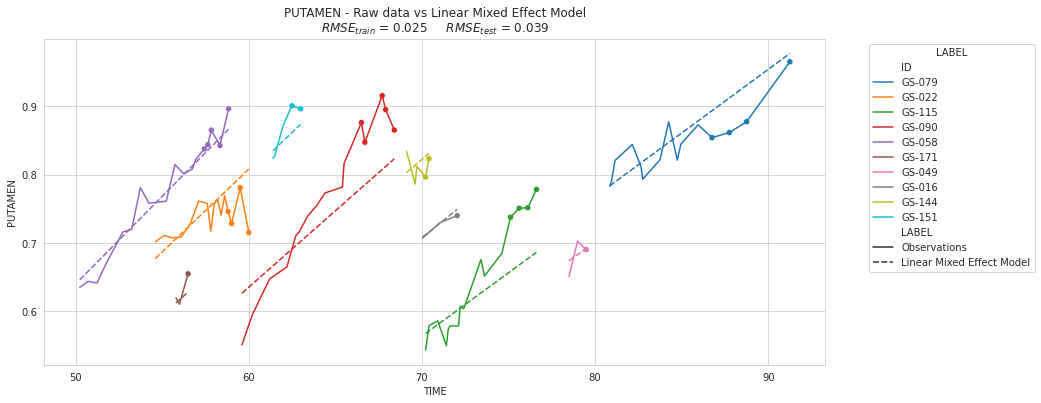

In [24]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

plot_individuals(df, overall_results, 'Linear Mixed Effect Model', sublist=sublist)
plt.show()

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> All the slopes are the same. This is related to the warning above : these are warnings are a way of alerting you that you may be in a non-standard situation. Most likely, one of your variance parameters is converging to zero. Which is the case if you have a look to time variance. 

<span style='color: #a13203; font-weight: 600;'>💬 Question 28 💬</span> Let's rerun it by normalizing the time first. Add to `df_train` and `df_test` a renormalizing function. Be careful to normalize only with the known ages from train.
_Hint_ : Watchout to data leakage!

In [25]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

# ---- We use only train data to compute mean & std
ages = df_train.index.get_level_values(1).values
age_mean = ages.mean()
age_std = ages.std()

df['TIME_NORMALIZED'] = (df.index.get_level_values('TIME') -  age_mean) / age_std

# ---- Split again train & test
df_train = df.xs('train',level='SPLIT')
df_test = df.xs('test',level='SPLIT')

<span style='color: #a13203; font-weight: 600;'>💬 Question 29 💬</span> Rerun the previous mixed lm (some cells above) but with the TIME_NORMALIZED instead of TIME in the formula and re_formula.

In [26]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #


lmm = smf.mixedlm(formula='PUTAMEN ~ TIME_NORMALIZED + 1', data=df_train.reset_index(), 
                  groups="ID", re_formula="~TIME_NORMALIZED + 1").fit()

lmm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                MixedLM     Dependent Variable:     PUTAMEN  
No. Observations:     1415        Method:                 REML     
No. Groups:           200         Scale:                  0.0005   
Min. group size:      2           Log-Likelihood:         2629.4084
Max. group size:      13          Converged:              Yes      
Mean group size:      7.1                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.679    0.016 43.031 0.000  0.648  0.710
TIME_NORMALIZED           0.231    0.011 20.134 0.000  0.209  0.254
ID Var                    0.045    0.288                           
ID x TIME_NORMALIZED Cov -0.006    0.111                           
TIME_NORMALIZED Var       0.017    0.126                           
===================================================================

"""

Ahaaaaah! No warnings!

<span style='color: #a13203; font-weight: 600;'>💬 Question 30 💬</span> Get the parameters as previously in `df_random_effects_2` and store the `INTERCEPT_NORMALIZED` and `SLOPE_NORMALIZED` 

In [27]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #


df_random_effects_2 = pd.DataFrame.from_dict(lmm.random_effects, orient='index')
df_random_effects_2 = df_random_effects_2.rename({'ID': 'Random intercept', 'TIME_NORMALIZED': 'Random slope'},
                                                 axis=1)


df_random_effects_2['INTERCEPT_NORMALIZED'] = df_random_effects_2['Random intercept'] + \
                                              lmm.fe_params.loc['Intercept']
df_random_effects_2['SLOPE_NORMALIZED'] = df_random_effects_2['Random slope'] + \
                                          lmm.fe_params.loc['TIME_NORMALIZED']

df_random_effects_2.head()

Random intercept  Random slope  INTERCEPT_NORMALIZED  SLOPE_NORMALIZED
GS-001         -0.222614      0.185999              0.456428          0.417479
GS-002          0.233375     -0.075922              0.912417          0.155558
GS-003          0.009845     -0.091712              0.688887          0.139767
GS-004         -0.093862      0.017902              0.585179          0.249382
GS-005          0.055686     -0.050411              0.734728          0.181068

Here, we computed 

$$ y = SLOPE_{normalized} * TIME_{normalized} + INTERCEPT_{normalized} $$ 

which corresponds to 

$$ y = SLOPE_{normalized} * \frac{(TIME - \mu(ages))}{ \sigma_{ages}} + INTERCEPT_{normalized} $$ 

which is : 

$$ y = SLOPE * TIME + INTERCEPT $$ 

where $$SLOPE = \frac{SLOPE_{normalized}}{ std_{ages}}$$ and $$INTERCEPT = INTERCEPT_{normalized} - \frac{SLOPE_{normalized} * mean_{ages}}{std_{ages}}$$


<span style='color: #a13203; font-weight: 600;'>💬 Question 31 💬</span> From INTERCEPT_NORMALIZED & SLOPE_NORMALIZED, compute for each subject its INTERCEPT and SLOPE:

```
parameters['GS-001'] 
>>> {'INTERCEPT': ..., 'SLOPE': ...}
```

In [28]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df_random_effects_2['SLOPE'] = df_random_effects_2['SLOPE_NORMALIZED'] / age_std
df_random_effects_2['INTERCEPT'] = df_random_effects_2['INTERCEPT_NORMALIZED'] -\
                                   (df_random_effects_2['SLOPE_NORMALIZED'] * age_mean)/age_std


<span style='color: #a13203; font-weight: 600;'>💬 Question 32 💬</span> Use the `compute_individual_reconstruction` function but with `df_random_effects_2` to compute the prediction with the new individual effects

In [29]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df['Linear Mixed Effect Model - V2'] = df.apply(
    lambda x: compute_individual_reconstruction(x, df_random_effects_2), axis=1)

<span style='color: #a13203; font-weight: 600;'>💬 Question 33 💬</span> Store the results in `overall_results` (thanks to `compute_rmse_train_test` function) and compare the models

In [30]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

compute_rmse_train_test(df, overall_results, 'Linear Mixed Effect Model - V2')

overall_results

train      test
Linear Regression               0.091403  0.102130
Individual Linear Regression    0.017825  0.032197
Linear Mixed Effect Model       0.024533  0.039367
Linear Mixed Effect Model - V2  0.019081  0.028939

The RMSE is much better!

<span style='color: #a13203; font-weight: 600;'>💬 Question 34 💬</span> Display the subjects of `sublist` :

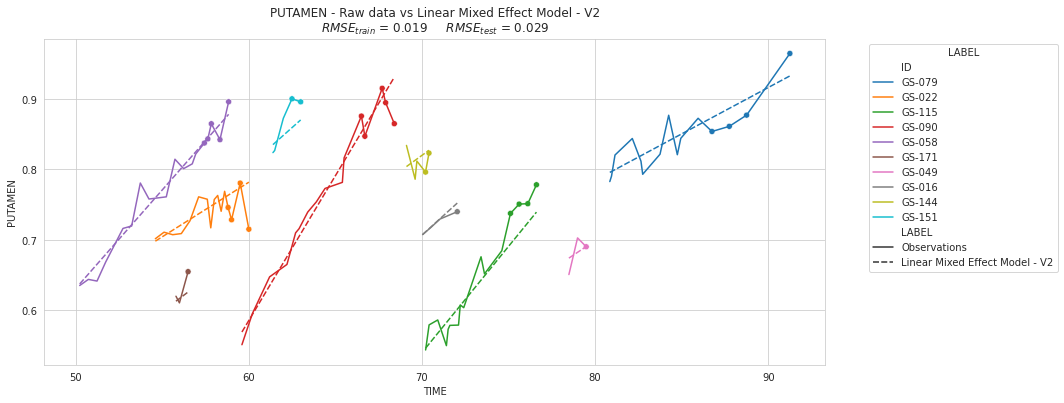

In [31]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

plot_individuals(df, overall_results, 'Linear Mixed Effect Model - V2', sublist=sublist)
plt.show()

<span style='color: #a13203; font-weight: 600;'>💬 Question 35 💬</span> What is the main advantage of a Linear Mixed-effects Model compared to multiple Linear Models ?

Instead of multiple models only one is fit such that overfitting is less likely. Subjects with only few data points can still be fitted appropriately as they are informed by the other subjects.

<span style='color: #a13203; font-weight: 600;'>💬 Question 36 💬</span> Let's check the average RMSE per subject depending of the number of timepoints per subjects:

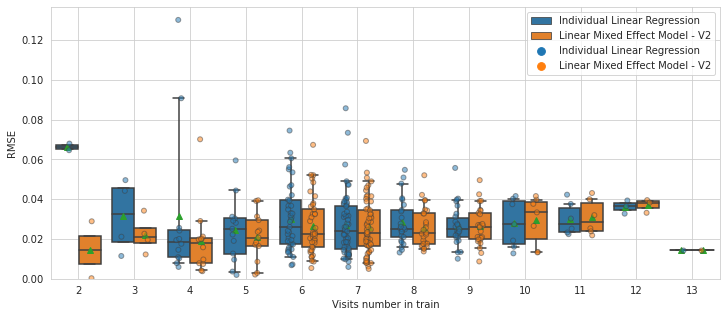

In [32]:
models = ['Individual Linear Regression', 'Linear Mixed Effect Model - V2']


def plot_rmse_by_number_of_visit(models, df=df):
    rmse = df[models].copy()
    rmse.columns.names = ['MODEL']
    rmse = rmse.stack()
    rmse = (rmse - df['PUTAMEN']) ** 2

    nbr_of_visits = rmse.xs('train',level='SPLIT').groupby(['MODEL','ID']).size()

    rmse = rmse.xs('test',level='SPLIT')
    rmse = rmse.reset_index().rename(columns={0: 'RMSE'})
    rmse = rmse.reset_index()[['ID', 'MODEL', 'RMSE']]
    rmse = rmse.groupby(['MODEL','ID']).mean() ** .5
    rmse['Visits number in train'] = nbr_of_visits

    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data=rmse.reset_index(), y='RMSE', 
                     x='Visits number in train', hue='MODEL', 
                     showmeans=True, whis=[5,95], showfliers=False)
    ax = sns.stripplot(data=rmse.reset_index(), y='RMSE', 
                       x='Visits number in train', hue='MODEL', 
                       dodge=True, alpha=.5, linewidth=1, ax=ax)

    plt.grid(True, axis='both')
    plt.ylim(0,None)
    plt.legend()
    return ax


plot_rmse_by_number_of_visit(models, df)
plt.show()

## PART VI: A taste of the future - Linear mixed-effect model with _Leaspy_


In the next practical sessions you will learn to use the package developped by the Aramis team. Now, just to be able to compare performances you will run a few methods of leaspy in advance...

<span style='color: #a13203; font-weight: 600;'>💬 Question 37 💬</span>  Run the following cell to make the import of leaspy methods, format the data and fit a model :

In [33]:
# --- Import methods
from leaspy import Leaspy, Data, AlgorithmSettings

# --- Format the data
data = Data.from_dataframe(df_train[['PUTAMEN']])

# --- Fit a model
leaspy_univariate = Leaspy('univariate_linear')
settings_fit = AlgorithmSettings('mcmc_saem', progress_bar=True, seed=0)
leaspy_univariate.fit(data, settings_fit)

 ==> Setting seed to 0
|##################################################|   10000/10000 iterations

Fit with `mcmc_saem` took: 22s
The standard deviation of the noise at the end of the fit is: 2.15%


Well it's a bit slow, but here is a joke to wait:
-    What did the triangle say to the circle? “You’re pointless.”

...


Okay, it was short. Here is another one:
-    I had an argument with a 90° angle. It turns out it was right.

<span style='color: #a13203; font-weight: 600;'>💬 Question 38 💬</span>  Run the following two cells to make the predictions:

In [34]:
settings_personalize = AlgorithmSettings('scipy_minimize', progress_bar=True, use_jacobian=True)

individual_parameters = leaspy_univariate.personalize(data, settings_personalize)

|##################################################|   200/200 subjects

Personalize with `scipy_minimize` took: 3s
The standard deviation of the noise at the end of the personalize is: 1.83%


In [35]:
timepoints = {idx: df.loc[idx].index.get_level_values('TIME').values for idx in 
              df.index.get_level_values('ID').unique()}
estimates = leaspy_univariate.estimate(timepoints, individual_parameters)

<span style='color: #a13203; font-weight: 600;'>💬 Question 39 💬</span>  Add the predictions to `df`

In [36]:
df['Leaspy linear'] = float('nan')

for idx in df.index.unique('ID'):
    df.loc[idx, 'Leaspy linear'] = estimates[idx]

<span style='color: #a13203; font-weight: 600;'>💬 Question 40 💬</span>  Compute and add the new rmse

In [37]:
compute_rmse_train_test(df, overall_results, 'Leaspy linear')

overall_results

train      test
Linear Regression               0.091403  0.102130
Individual Linear Regression    0.017825  0.032197
Linear Mixed Effect Model       0.024533  0.039367
Linear Mixed Effect Model - V2  0.019081  0.028939
Leaspy linear                   0.018316  0.027711

<span style='color: #a13203; font-weight: 600;'>💬 Question 41 💬</span> Display the subjects of `sublist` :

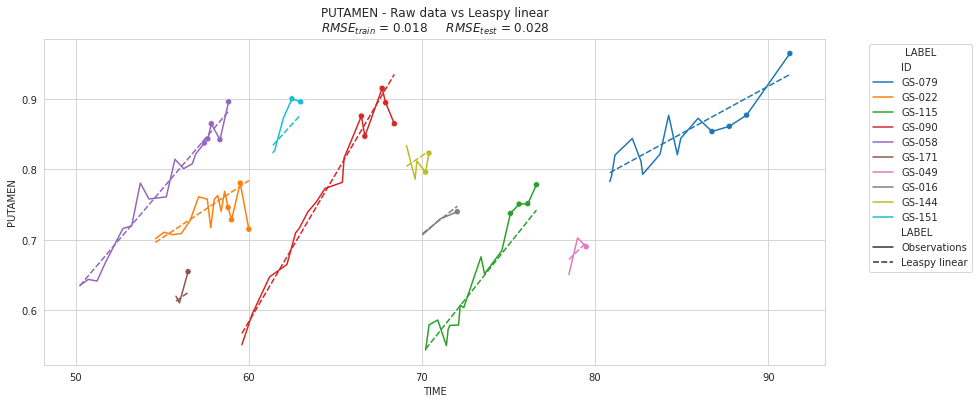

In [38]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

plot_individuals(df, overall_results, 'Leaspy linear', sublist=sublist)
plt.show()

## PART VII: A taste of the future - Non-linear mixed-effect model with _Leaspy_

Again you will use an other model of leapsy...

<span style='color: #a13203; font-weight: 600;'>💬 Question 42 💬</span> Fit the model with the data.

In [39]:
leaspy_univariate = Leaspy('univariate_logistic')
settings_fit = AlgorithmSettings('mcmc_saem', progress_bar=True, seed=0)
leaspy_univariate.fit(data, settings_fit)

 ==> Setting seed to 0
|##################################################|   10000/10000 iterations

Fit with `mcmc_saem` took: 24s
The standard deviation of the noise at the end of the fit is: 2.14%


<span style='color: #a13203; font-weight: 600;'>💬 Question 43 💬</span>  Run the following two cells to make the predictions:

In [40]:
settings_personalize = AlgorithmSettings('scipy_minimize', progress_bar=True, use_jacobian=True)

individual_parameters = leaspy_univariate.personalize(data, settings_personalize)

|##################################################|   200/200 subjects

Personalize with `scipy_minimize` took: 4s
The standard deviation of the noise at the end of the personalize is: 1.83%


In [41]:
timepoints = {idx: df.loc[idx].index.get_level_values('TIME').values for idx in 
              df.index.get_level_values('ID').unique()}
estimates = leaspy_univariate.estimate(timepoints, individual_parameters)

<span style='color: #a13203; font-weight: 600;'>💬 Question 44 💬</span>  Add the predictions to `df`

In [42]:
df['Leaspy logistic'] = float('nan')

for idx in df.index.unique('ID'):
    df.loc[idx, 'Leaspy logistic'] = estimates[idx]

<span style='color: #a13203; font-weight: 600;'>💬 Question 45 💬</span>  Compute and add the new rmse

In [43]:
compute_rmse_train_test(df, overall_results, 'Leaspy logistic')

overall_results

train      test
Linear Regression               0.091403  0.102130
Individual Linear Regression    0.017825  0.032197
Linear Mixed Effect Model       0.024533  0.039367
Linear Mixed Effect Model - V2  0.019081  0.028939
Leaspy linear                   0.018316  0.027711
Leaspy logistic                 0.018303  0.026781

<span style='color: #a13203; font-weight: 600;'>💬 Question 46 💬</span> Display the subjects of `sublist` :

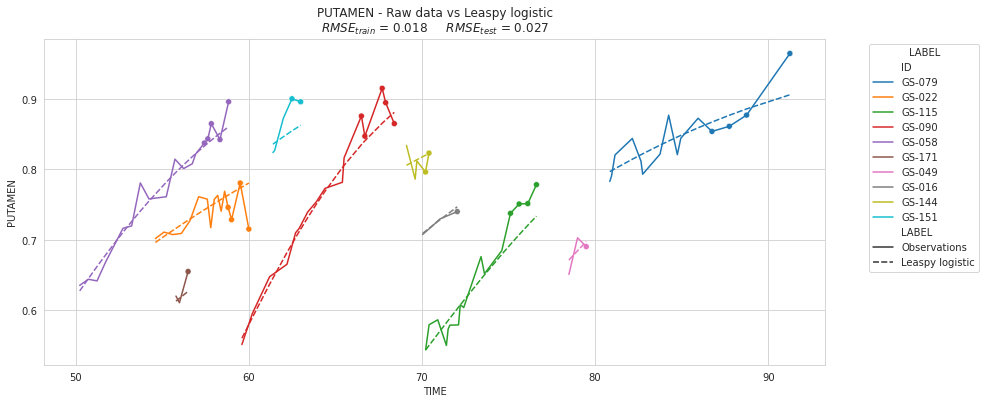

In [44]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

plot_individuals(df, overall_results, 'Leaspy logistic', sublist=sublist)
plt.show()

<span style='color: #a13203; font-weight: 600;'>💬 Question 47 💬</span> Check the average RMSE per subject depending of the number of timepoints per subjects

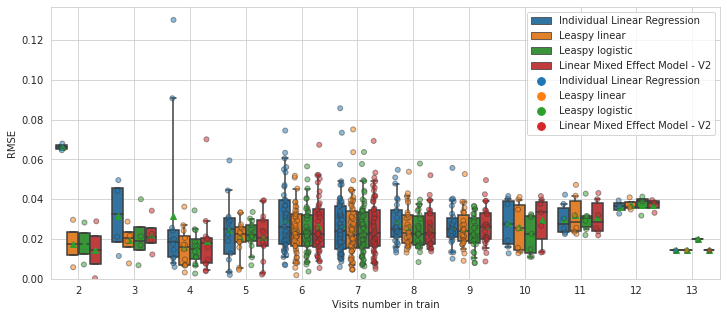

In [45]:
models = ['Individual Linear Regression', 
          'Linear Mixed Effect Model - V2',
          'Leaspy linear',
          'Leaspy logistic']


plot_rmse_by_number_of_visit(models, df)
plt.show()

Here we clearly see that the few subjects who have less than 6 timepoints are better reconstructed with a mixed effect model!

## For the fast-running Zebras: all-in-one with a more realistic split of data

Let's try to split differently data so to mimic real-world applications.

We don't want to fit again a new model every time we predict the future of a new patient.
To this aim, we want to calibrate (fit) a model on a large and representative dataset once and then personalize this model to totally new individuals. We can then make forecasts about these new individuals.

The previous split was not taking into account this constraint and this extra part will go through it.

- **Train** part: all data from some individuals (used for **calibration** of model)
- **Test** part: new individuals
  - _Present_ data: partial data of these new individuals that will be _known_ (used for **personalization** of model)
  - _Future_ data: hidden data from these individuals (not known during personalization, used for **prediction**)

<span style='color: #a13203; font-weight: 600;'>💬 Question 48 💬</span> Split data differently so to respect real-world constraint

In [46]:
# be sure that ages are increasing
df.sort_index(inplace=True)

individuals = df.index.unique('ID')
n_individuals = len(individuals)

# split on individuals
fraction = .75
individuals_train, individuals_test = individuals[:int(fraction*n_individuals)], individuals[int(fraction*n_individuals):]

s_train = df.droplevel(-1).loc[individuals_train][['PUTAMEN']]
s_test = df.droplevel(-1).loc[individuals_test][['PUTAMEN']]

# we split again test set in 2 parts: present (known) / future (to predict)
s_test_future = s_test.groupby('ID').tail(2) # 2 last tpts
s_test_present = s_test.loc[s_test.index.difference(s_test_future.index)]

s_test.loc[s_test_future.index, 'PART'] = 'future'
s_test.loc[s_test_present.index, 'PART'] = 'present'

s_test.set_index('PART',append=True,inplace=True)

# check no intersection in individuals between train/test
assert len(s_train.index.unique('ID').intersection(s_test.index.unique('ID'))) == 0

# check no intersection of (individual, timepoints) between test present/future
assert len(s_test_present.index.intersection(s_test_future.index)) == 0

# Leaspy Data objects creation
data_train = Data.from_dataframe(s_train)
data_test = {
    'all': Data.from_dataframe(s_test.droplevel('PART')), # all test data [present+future pooled]
    'present': Data.from_dataframe(s_test_present),
    'future': Data.from_dataframe(s_test_future)
}

Let's check that distributions of ages and putamen values between train & test are similar... unlike previous split!

<span style='color: #a13203; font-weight: 600;'>💬 Question 49 💬</span> Check consistence of new train/test split and compare to previous split

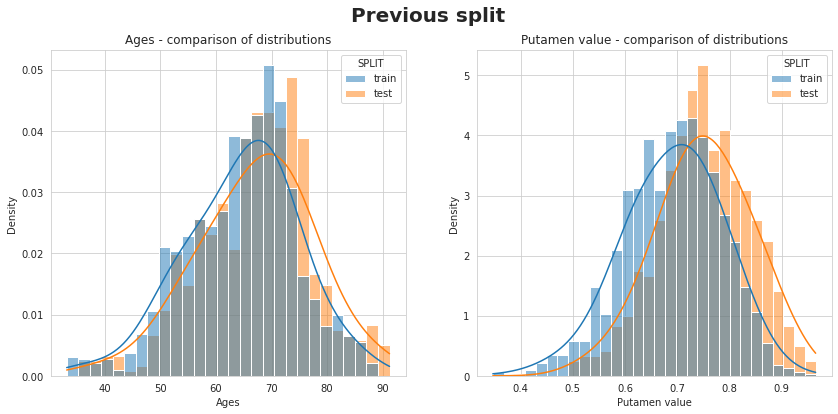

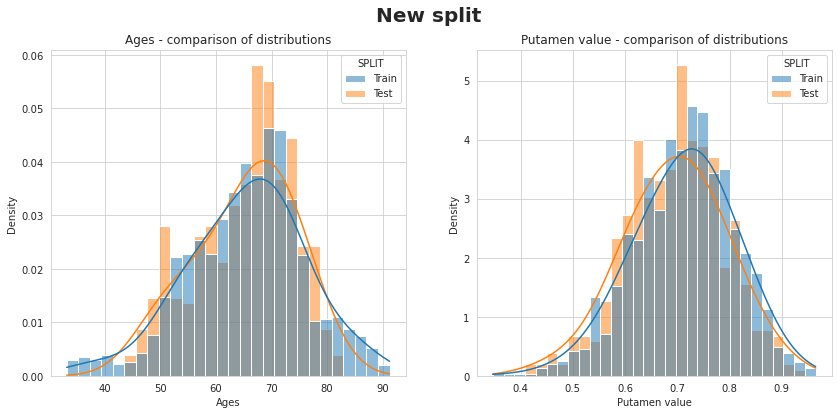

In [47]:
df_new_split = pd.concat({
    'Train': s_train,
    'Test': s_test.droplevel(-1)
}, names=['SPLIT'])

for which_split, df_split in {'Previous split': df, 'New split': df_new_split}.items():
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(which_split, fontsize=20, fontweight='bold')
    
    for (var, title), ax in zip({'TIME': 'Ages', 'PUTAMEN': 'Putamen value'}.items(), axs):

        sns.histplot(data=df_split.reset_index(), x=var, 
                     hue='SPLIT', stat='density', common_norm=False, 
                     kde=True, kde_kws=dict(bw_adjust=2.), ax=ax)
        ax.set_title(f'{title} - comparison of distributions')
        ax.set_xlabel(title)

    plt.show()

#sns.scatterplot(data=s_train.reset_index(), 
#                x='TIME', y='PUTAMEN', alpha=.5, s=60)
#sns.scatterplot(data=s_test.reset_index(), 
#                x='TIME', y='PUTAMEN', alpha=.5, s=60)

<span style='color: #a13203; font-weight: 600;'>💬 Question 50 💬</span> Double check number of individuals and visits in each split of our dataset

In [48]:
# Some descriptive stats on number of visits in test set (present part)

pd.options.display.float_format = '{:.1f}'.format

print('Visits in each split')
print({'Train': len(s_train), 
       'All test': len(s_test), 
       'Test - known part': len(s_test_present),
       'Test - to predict part': len(s_test_future)
      })
print()

print('Visits per individual in each split')
pd.concat({
    'Calibration': s_train.groupby('ID').size().describe(percentiles=[]), # min: 3 tpts known
    'Personalization': s_test_present.groupby('ID').size().describe(percentiles=[]), # min: 1 tpt known
    'Prediction': s_test_future.groupby('ID').size().describe(percentiles=[]), # min: 2 tpts to predict
}).unstack(0).rename({'count':'nb of individuals'}, axis=0)

Visits in each split
{'Train': 1499, 'All test': 498, 'Test - known part': 398, 'Test - to predict part': 100}

Visits per individual in each split


Calibration  Personalization  Prediction
nb of individuals        150.0             50.0        50.0
mean                      10.0              8.0         2.0
std                        2.5              2.5         0.0
min                        3.0              1.0         2.0
50%                       10.0              8.0         2.0
max                       18.0             13.0         2.0

<span style='color: #a13203; font-weight: 600;'>💬 Question 51 💬</span> Write a all-in-one personalization & prediction function thanks to Leaspy api

In [49]:
def personalize_model(leaspy_model, settings_perso):
    """
    all-in-one function that:
    1. takes a calibrated leaspy model, 
    2. personalizes it with different splits of data
    3. and estimates prediction errors compared to real data (including the hidden parts)
    """

    ips_test = {}
    rmse_test = {}

    # personalize on train part just to have a comparison (baseline)
    ips_test['train'], rmse_test['train'] = leaspy_model.personalize(data_train, settings_perso, 
                                                                     return_noise=True)
    print(f'RMSE on train: {100*rmse_test["train"]:.2f}%')

    # personalize using different test parts
    for test_part, data_test_part in data_test.items():
        ips_test[test_part], rmse_test[test_part] = leaspy_model.personalize(data_test_part, settings_perso, 
                                                                             return_noise=True)
        print(f'RMSE on test {test_part}: {100*rmse_test[test_part]:.2f}%')
    
    # reconstruct using different personalizations made
    s_train_ix = s_train.assign(PART='train').set_index('PART',append=True).index # with fake part added
    
    all_recons_df = pd.concat({
        test_part: leaspy_model.estimate(s_test.index if test_part != 'train' else s_train_ix, 
                                         ips_test_part)
        for test_part, ips_test_part in ips_test.items()
    }, names=['PERSO_ON']).reorder_levels([1,2,3,0])

    # compute prediction errors made
    true_vals_same_ix = all_recons_df[[]].join(df.droplevel(-1).iloc[:,0])
    pred_errs = all_recons_df - true_vals_same_ix
    
    # return everything that could be needed
    return pred_errs, all_recons_df, ips_test, rmse_test

<span style='color: #a13203; font-weight: 600;'>💬 Question 52 💬</span> Calibrate, personalize & predict with LMM, univariate linear & univariate logistic thanks to Leaspy

In [50]:
## Leaspy LMM (using integrated exact personalization formula)

leaspy_lmm = Leaspy('lme')
settings_fit = AlgorithmSettings('lme_fit', 
                                 with_random_slope_age=True,
                                 force_independent_random_effects=True, # orthogonal rand. eff.
                                 seed=0)

# ------- Compute population parameters on train data ------- 
# (fixed effects, noise level and var-covar of random effects)
leaspy_lmm.fit(data_train, settings_fit)

# ------- Compute individual parameters (random effects) on different splits -------
pred_errs_lmm, all_recons_df_lmm, _, _  = personalize_model(leaspy_lmm, AlgorithmSettings('lme_personalize'))

 ==> Setting seed to 0


/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/leaspy/algo/others/lme_fit.py:90: FutureWarning: You should define {'with_random_slope_age': True} directly as hyperparameters of LME model. The current behaviour will soon be dropped.
  warnings.warn(f'You should define {model_hps_in_algo_settings} directly as hyperparameters of LME model. '



Fit with `lme_fit` took: 1s
The standard deviation of the noise at the end of the fit is: 2.18%

Personalize with `lme_personalize` took: 0s
The standard deviation of the noise at the end of the personalize is: 1.98%
RMSE on train: 1.98%

Personalize with `lme_personalize` took: 0s
The standard deviation of the noise at the end of the personalize is: 1.91%
RMSE on test all: 1.91%

Personalize with `lme_personalize` took: 0s
The standard deviation of the noise at the end of the personalize is: 1.88%
RMSE on test present: 1.88%

Personalize with `lme_personalize` took: 0s
The standard deviation of the noise at the end of the personalize is: 1.61%
RMSE on test future: 1.61%


In [51]:
## Leaspy univariate linear
leaspy_lin = Leaspy('univariate_linear')
settings_fit = AlgorithmSettings('mcmc_saem', n_iter=8000, progress_bar=True, seed=0)
settings_perso = AlgorithmSettings('scipy_minimize', progress_bar=True, use_jacobian=True)

# ------- Compute population parameters on train data ------- 
leaspy_lin.fit(data_train, settings_fit)

# ------- Compute individual parameters on different splits -------
pred_errs_lin, all_recons_df_lin, _, _  = personalize_model(leaspy_lin, settings_perso)

 ==> Setting seed to 0
|##################################################|   8000/8000 iterations

Fit with `mcmc_saem` took: 17s
The standard deviation of the noise at the end of the fit is: 2.15%
|##################################################|   150/150 subjects

Personalize with `scipy_minimize` took: 3s
The standard deviation of the noise at the end of the personalize is: 1.94%
RMSE on train: 1.94%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is: 1.85%
RMSE on test all: 1.85%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is: 1.77%
RMSE on test present: 1.77%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the

In [52]:
## Leaspy univariate logistic
leaspy_log = Leaspy('univariate_logistic')

# Calibrate
leaspy_log.fit(data_train, settings_fit)

# Personalize
pred_errs_log, all_recons_df_log, _, _  = personalize_model(leaspy_log, settings_perso)

 ==> Setting seed to 0
|##################################################|   8000/8000 iterations

Fit with `mcmc_saem` took: 20s
The standard deviation of the noise at the end of the fit is: 2.15%
|##################################################|   150/150 subjects

Personalize with `scipy_minimize` took: 3s
The standard deviation of the noise at the end of the personalize is: 1.94%
RMSE on train: 1.94%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is: 1.84%
RMSE on test all: 1.84%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is: 1.77%
RMSE on test present: 1.77%
|##################################################|   50/50 subjects

Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the

<span style='color: #a13203; font-weight: 600;'>💬 Question 53 💬</span> Display RMSE on all splits of data depending on models & part where models were personalized on

In [53]:
# reconstruct using different personalizations made
pd.options.display.float_format = '{:.5f}'.format

all_pred_errs = pd.concat({
    'lmm': pred_errs_lmm,
    'leaspy_linear': pred_errs_lin,
    'leaspy_logistic': pred_errs_log,
}, names=['MODEL'])

print('RMSE by:\n- model\n- part of data for personalization\n- part of data for reconstruction\n')

rmses_by_perso_split = (all_pred_errs**2).groupby(['MODEL','PERSO_ON','PART']).mean() ** .5
rmses_by_perso_split.unstack('MODEL').droplevel(0, axis=1).sort_index(ascending=[True,False]).rename_axis(index={'PART':'RECONS_ON'})

RMSE by:
- model
- part of data for personalization
- part of data for reconstruction



MODEL                  lmm  leaspy_linear  leaspy_logistic
PERSO_ON RECONS_ON                                        
all      present   0.01897        0.01841          0.01819
         future    0.01944        0.01904          0.01915
future   present   0.04730        0.04764          0.04956
         future    0.01609        0.01610          0.01621
present  present   0.01880        0.01775          0.01774
         future    0.02692        0.02650          0.02554
train    train     0.01979        0.01942          0.01940

<span style='color: #a13203; font-weight: 600;'>💬 Question 54 💬</span> Plot distributions of absolute errors

In [54]:
def plot_dist_errs(pred_errs, model_name, grouping_reverse=False):
    plt.figure(figsize=(14,6))
    plt.grid(True,axis='both',zorder=-1)

    plot_opts = dict(
        x='PART', order=['train','present','future'],
        hue='PERSO_ON', hue_order=['all','present','future','train'],
    )
    x_lbl = 'Part of test set we look errors at'
    legend_lbl = 'Personalization on\nwhich test part?'
    
    if grouping_reverse:
        plot_opts = dict(
            hue='PART', hue_order=['train','present','future'],
            x='PERSO_ON', order=['all','present','future','train'],
        )
        x_lbl, legend_lbl = legend_lbl, x_lbl # swap
    
    sns.boxplot(data=pred_errs.abs().reset_index(),
                y='PUTAMEN', **plot_opts, showfliers=False)

    plt.ylabel(f'Distribution of {model_name} absolute errors', fontsize=14)
    
    plt.xlabel(x_lbl, fontsize=14)
    plt.legend().set_title(legend_lbl)

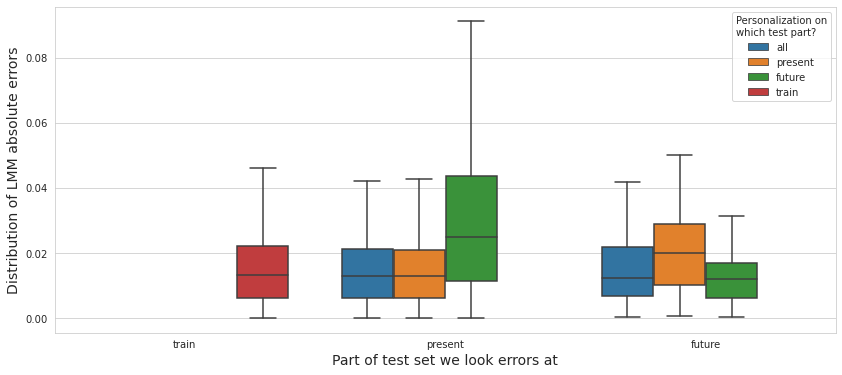

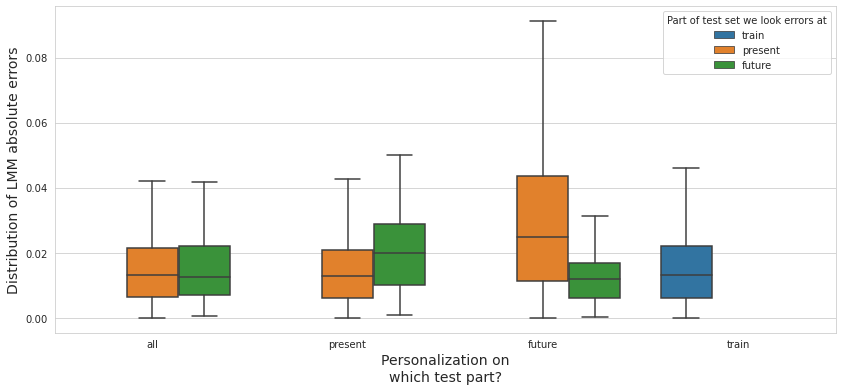

In [55]:
plot_dist_errs(pred_errs_lmm, 'LMM')
plot_dist_errs(pred_errs_lmm, 'LMM', True)

<span style='color: #a13203; font-weight: 600;'>💬 Question 55 💬</span> Plot some individual trajectories with their associated predicted trajectories

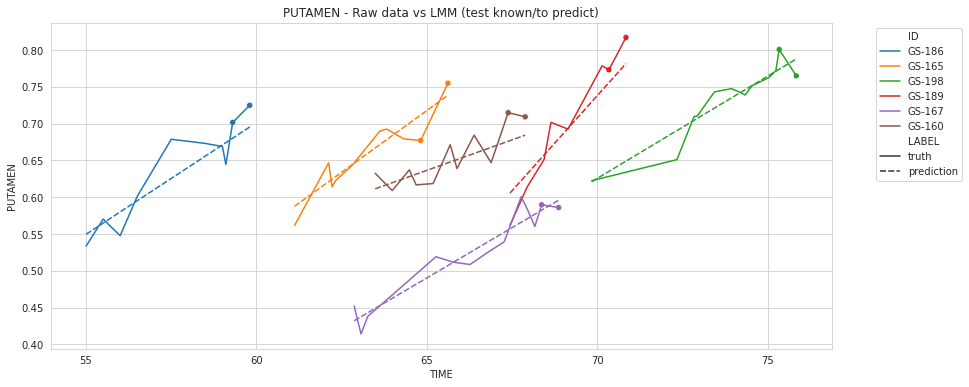

In [57]:
idx_list = np.random.RandomState(5).choice(s_test.index.unique('ID'), 6).tolist()

def plot_recons(all_recons_df, model_name):

    recontruction_and_raw_data = pd.concat({'truth': s_test, 
                                            'prediction': all_recons_df.xs('present', level='PERSO_ON')
                                           }, names=['LABEL']).swaplevel(0,1).sort_index()

    plt.figure(figsize=(14,6))

    sns.lineplot(data=recontruction_and_raw_data.loc[idx_list].reset_index(), 
                 x='TIME', y='PUTAMEN', hue='ID', style='LABEL', style_order=['truth','prediction'])

    sns.scatterplot(data=s_test_future.loc[idx_list].reset_index(),  
                    x='TIME', y='PUTAMEN', hue='ID', legend=None)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    title = f'PUTAMEN - Raw data vs {model_name} (test known/to predict)'
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_recons(all_recons_df_lmm, 'LMM')
#plot_recons(all_recons_df_lin, 'Leaspy linear (univ.)')
#plot_recons(all_recons_df_log, 'Leaspy logistic (univ.)')

## Bonus: have a look at the LMM log-likelihood landscape

In [58]:
import statsmodels.formula.api as smf
from tqdm import tqdm

import site
site.addsitedir('./utils')

from loglikelihood_landspace_lmm import plt_ll_landscape, plt_ll_landscape_

# new model (TIME_norm)
lmm_model = smf.mixedlm(formula="PUTAMEN ~ 1 + TIME_NORMALIZED", 
                        data=df.xs('train',level='SPLIT').reset_index(), 
                        groups="ID", re_formula="~ 1 + TIME_NORMALIZED")

lmm_model.cov_pen = None

view = dict(
    vmin=2200,
    vmid=2500, 
    vmax=2630, 
    levels=[2500, 2600, 2620]
)

Rs = {} # placeholder for results

ModuleNotFoundError: No module named 'loglikelihood_landspace_lmm'

<span style='color: #a13203; font-weight: 600;'>💬 Question 56 💬</span> Plot log-likelihood landscapes for LMM model, depending on variance-covariance matrix of random effects

  0%|          | 0/18 [00:00<?, ?it/s]

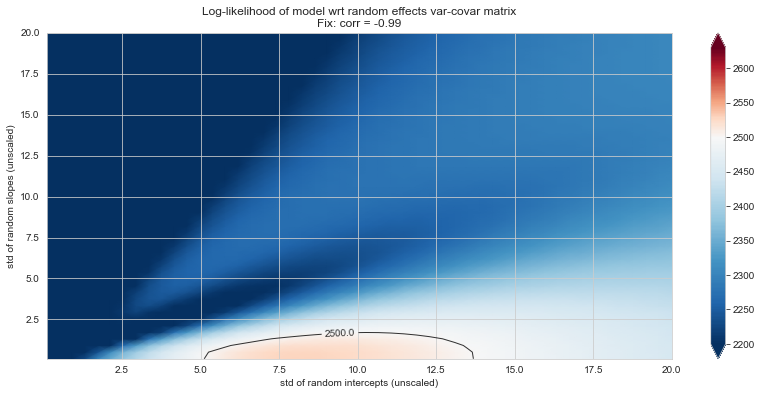

  6%|▌         | 1/18 [01:23<23:39, 83.51s/it]

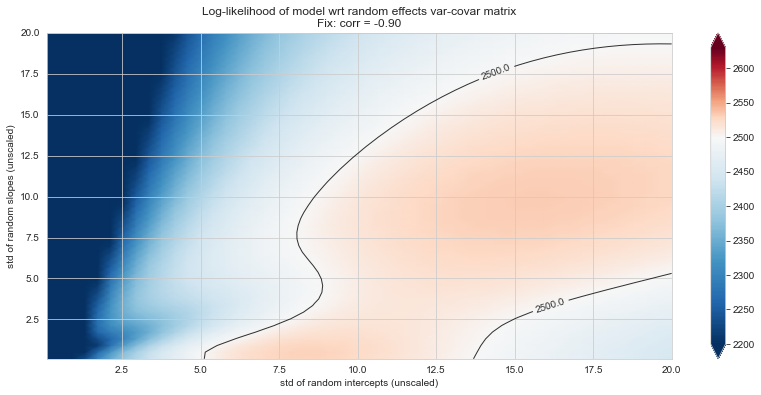

 11%|█         | 2/18 [02:58<24:06, 90.39s/it]

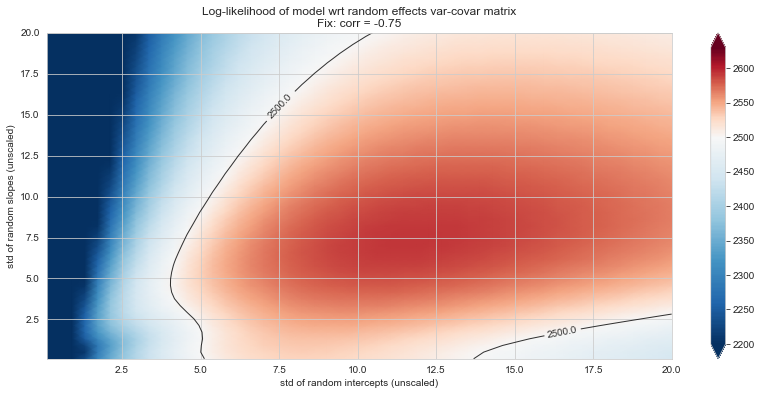

 17%|█▋        | 3/18 [04:43<24:16, 97.10s/it]

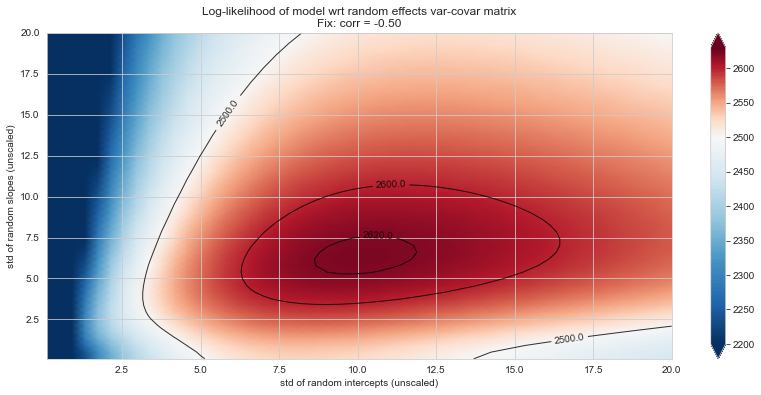

 22%|██▏       | 4/18 [06:01<20:53, 89.53s/it]

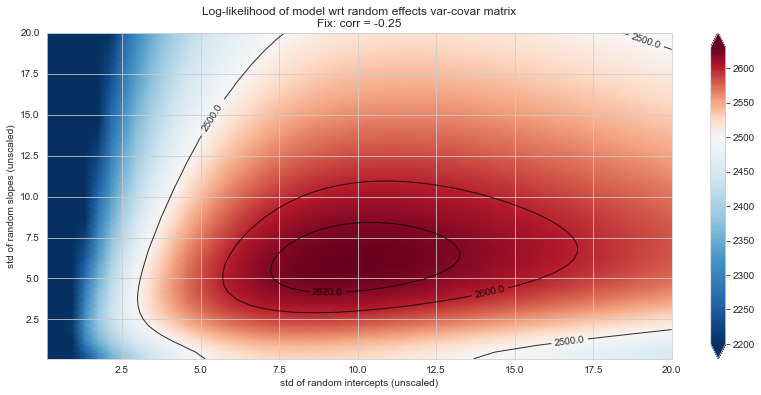

 28%|██▊       | 5/18 [07:27<19:04, 88.05s/it]

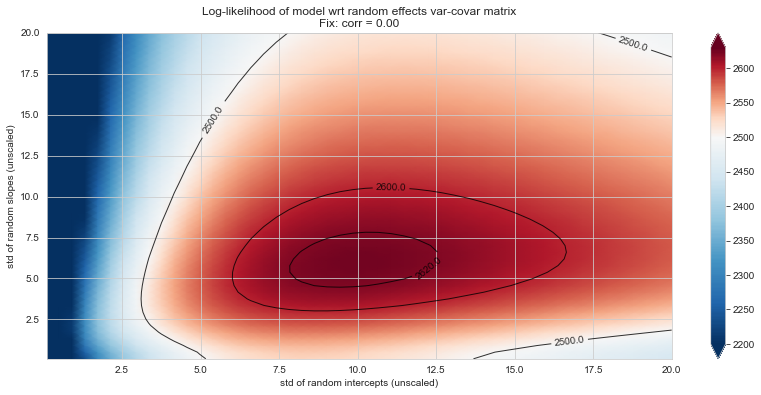

 33%|███▎      | 6/18 [08:53<17:31, 87.61s/it]

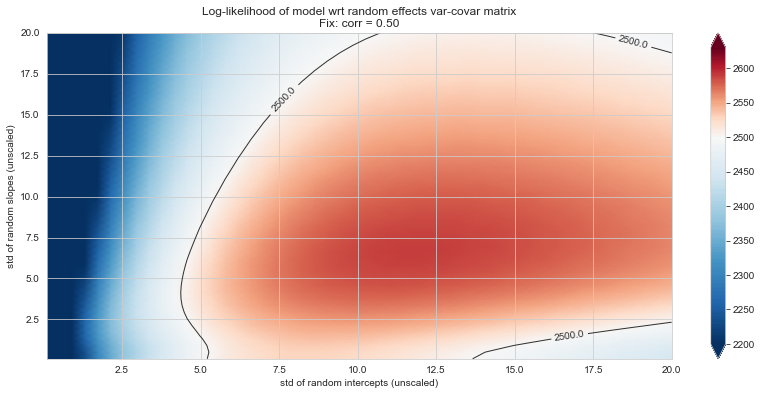

 39%|███▉      | 7/18 [10:06<15:08, 82.59s/it]

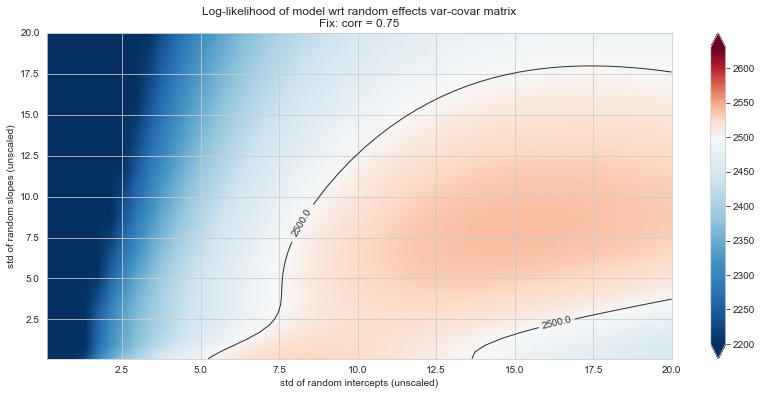

 44%|████▍     | 8/18 [11:19<13:17, 79.72s/it]

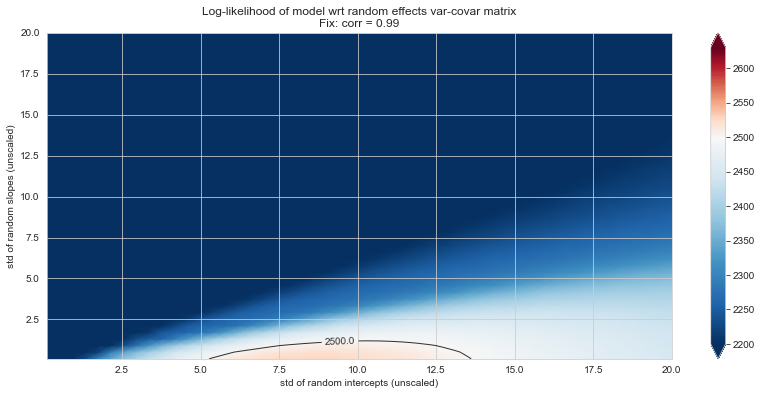

 50%|█████     | 9/18 [12:31<11:35, 77.33s/it]/Users/etienne.maheux/Documents/repos/disease-course-mapping-solutions/TP1_LMM/utils/loglikelihood_landspace_lmm.py:130: UserWarning: No contour levels were found within the data range.
  colors='black', alpha=.8, linewidths=1)


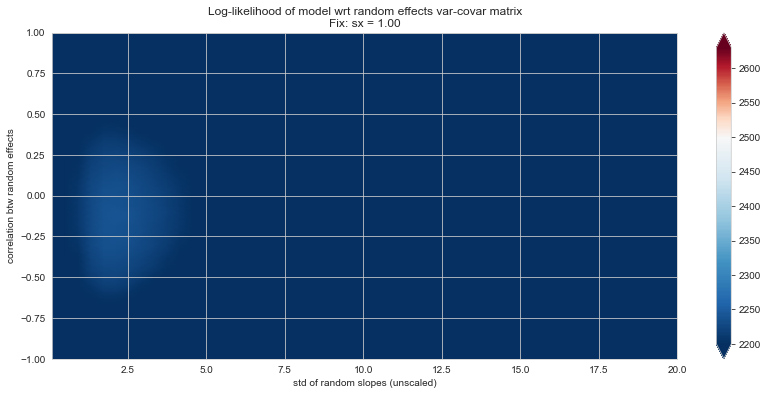

 56%|█████▌    | 10/18 [13:44<10:07, 75.94s/it]

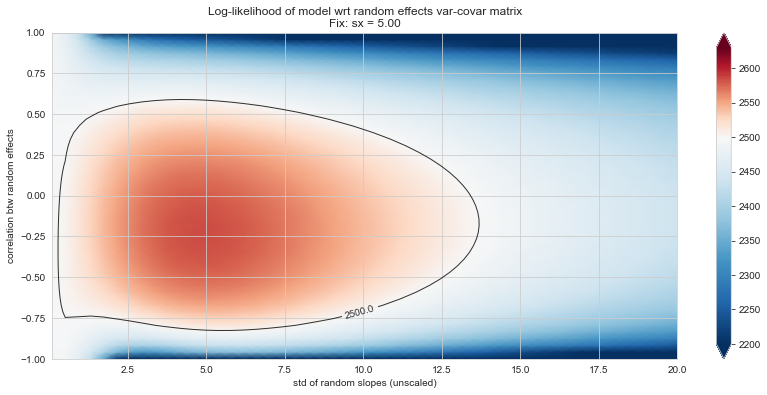

 61%|██████    | 11/18 [14:58<08:46, 75.22s/it]

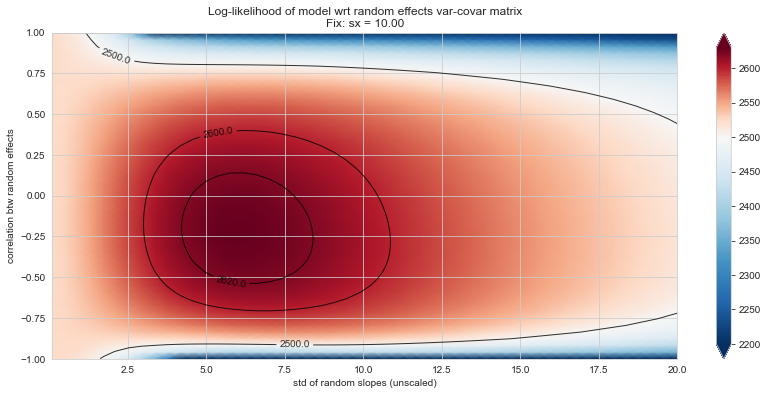

 67%|██████▋   | 12/18 [16:11<07:27, 74.57s/it]

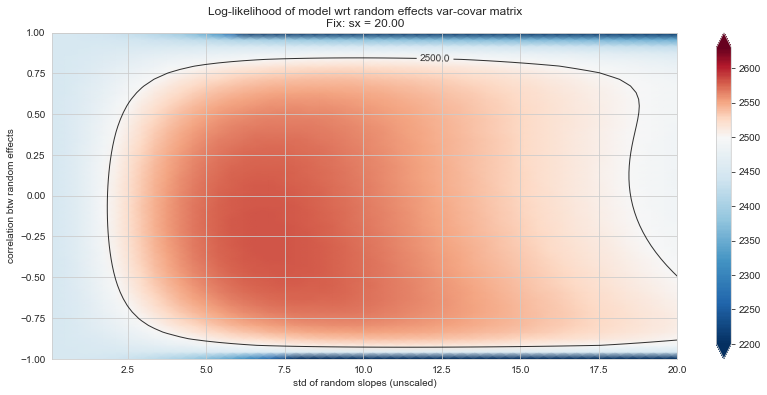

 72%|███████▏  | 13/18 [17:24<06:10, 74.09s/it]

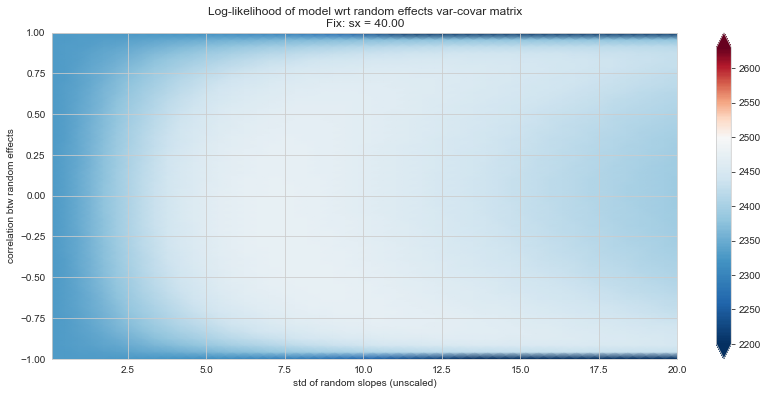

 78%|███████▊  | 14/18 [18:38<04:56, 74.21s/it]

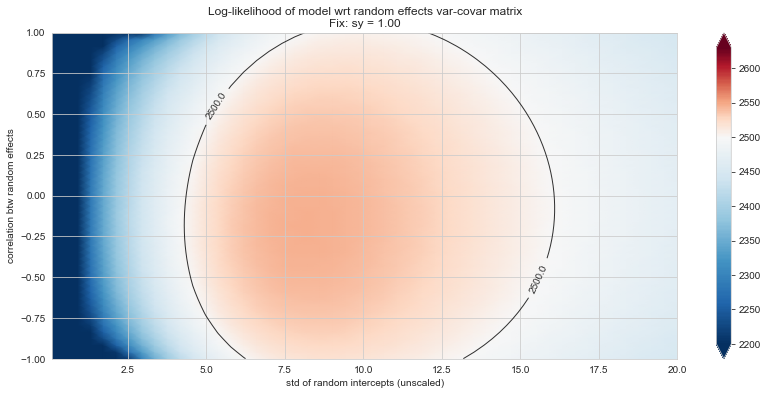

 83%|████████▎ | 15/18 [19:56<03:45, 75.18s/it]

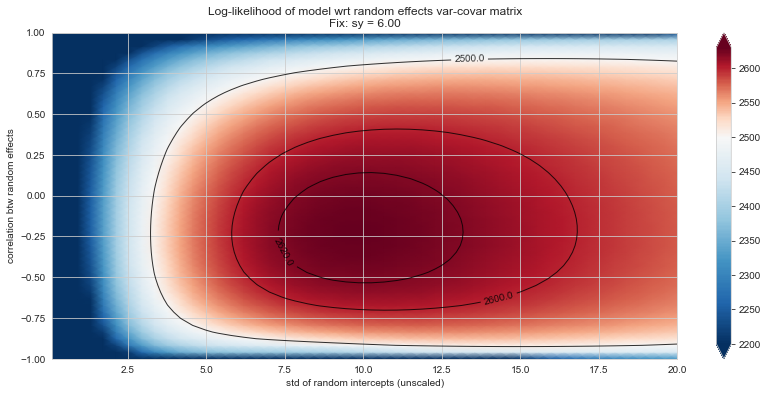

 89%|████████▉ | 16/18 [21:14<02:32, 76.14s/it]

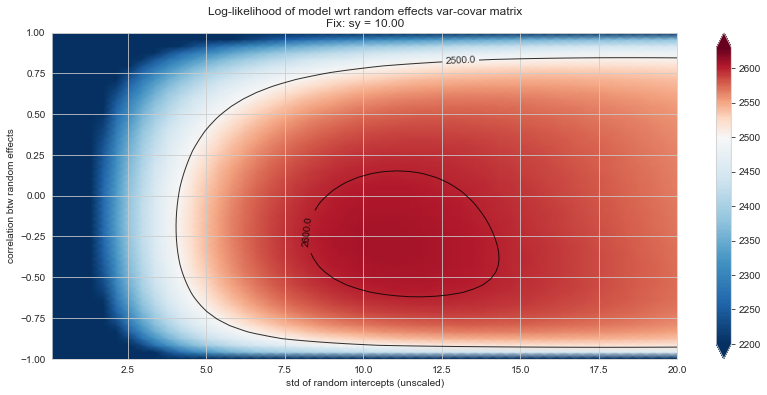

 94%|█████████▍| 17/18 [22:27<01:15, 75.09s/it]

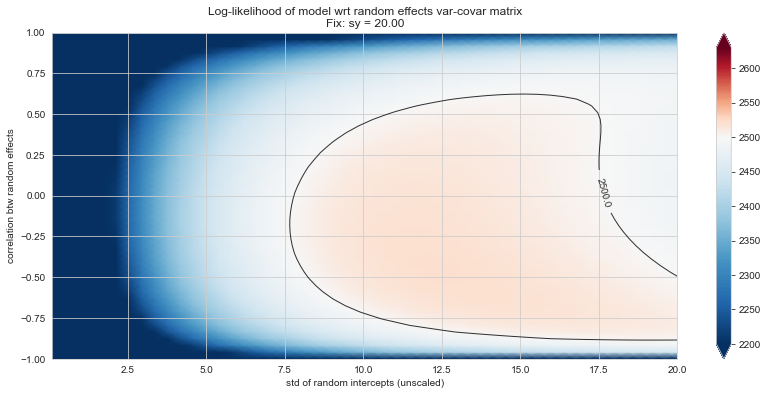

100%|██████████| 18/18 [23:52<00:00, 79.58s/it]


In [203]:
for fix_k, fix_v in tqdm([
    # corr fixed
    ('corr', -.99),
    ('corr', -.9),
    ('corr', -.75),
    ('corr', -.5),
    ('corr', -.25), # ~best
    ('corr', 0),
    ('corr', .5),
    ('corr', .75),
    ('corr', .99),
    # sx fixed
    ('sx', 1.),
    ('sx', 5),
    ('sx', 10), # ~best
    ('sx', 20),
    ('sx', 40),
    # sy fixed
    ('sy', 1),
    ('sy', 6), # ~best
    ('sy', 10),
    ('sy', 20),
]):
    if (fix_k, fix_v) in Rs:
        plt_ll_landscape_(Rs[(fix_k, fix_v)], **view)
    else:
        Rs[(fix_k, fix_v)] = plt_ll_landscape(lmm_model, N=50, **{fix_k: fix_v}, **view)